In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"]='1'

# 사전 학습 모델 불러오기

In [2]:
pretrained_Model = tf.keras.applications.MobileNetV2(include_top = True, weights='imagenet')
pretrained_Model.trainable=False

# 이미지 불러오기 및 전처리

In [3]:
dir_path='../voltage_anomaly_detection/'

val_img = []
for file in os.listdir(dir_path+"cat/"): 
    val_img.append(cv2.imread(dir_path+'cat/'+file))

In [4]:
def preprocess(image):
    image=tf.cast(image,tf.float32)
    image/=255
    image=tf.image.resize(image,(224,224))
    image=image[None, ...]
    return image

def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [5]:
preprocessed_images=[]
for i in range(0,len(val_img),1):
    img=preprocess(val_img[int(i)])
    preprocessed_images.append(img)

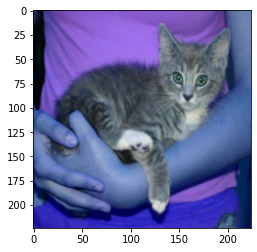

In [6]:
# 전처리 확인
plt.figure()
plt.imshow(preprocessed_images[2][0])

# 사전 학습된 모델을 통해 예측값 출력

In [7]:
probs = []
for i in range(len(val_img)):
    image_probs=pretrained_Model.predict(preprocessed_images[i])
    probs.append(image_probs)

In [8]:
# ImageNet 클래스 레이블
decode_predictions=tf.keras.applications.mobilenet_v2.decode_predictions
classes=[]
for i in range(len(val_img)):
    _,image_class,class_confidence=get_imagenet_label(probs[i])
    classes.append(image_class)

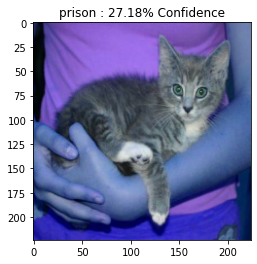

In [9]:
plt.figure()
plt.imshow(preprocessed_images[2][0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

# Unadversarial Patch 생성을 위한 랜덤 패치 생성

In [10]:
patch = np.random.rand(56,56,3)
patch = patch.reshape((1,56,56,3))

In [11]:
patch.shape

(1, 56, 56, 3)

# Loss의 Sign(부호)를 얻기 위한 함수

In [12]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def get_sign(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_Model(input_image)
        loss = loss_object(input_label, prediction)

      # 입력 이미지에 대한 손실 함수의 기울기를 구합니다.
    gradient = tape.gradient(loss, input_image)
      # 왜곡을 생성하기 위해 그래디언트의 부호를 구합니다.
    signed_grad = tf.sign(gradient)
    return signed_grad

# Patch 생성

In [14]:
import random
from random import * 

persian_cat_index = 283 # Persian_cat label에 대한 Unadversarial Patch를 생성하기 위해 ImageNet One-hot 정보를 가져옴
label = tf.one_hot(persian_cat_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

for K in range(900):
    # 무작위로 image-label 쌍 선택
    i = randint(0, len(preprocessed_images)-1)
    rand_theta = randint(0,6)
    rand_shear = randint(0,3)
    selected_image = preprocessed_images[i]
    selected_class = classes[i]
    if selected_class == "Egyptian_cat":
        padded_patch=np.pad(patch[0], ((84,84), (84,84), (0, 0)), mode = 'constant', constant_values = 0) # Zero-pad Patch
        mask = np.where(padded_patch > 0, True, False) # Mask
        T_mask = tf.keras.preprocessing.image.apply_affine_transform(1*mask,theta=rand_theta,shear=rand_shear)
        T_patch = tf.keras.preprocessing.image.apply_affine_transform(padded_patch,theta=rand_theta,shear=rand_shear)
        Unadv_example = preprocessed_images[i]*(tf.zeros((224,224,3))-T_mask)+T_patch*T_mask
        sign = get_sign(Unadv_example, label)
        padded_patch = padded_patch - 0.005*sign

# Patch가 있는 image와 일반 이미지의 Accuracy 비교

Patch가 추가된 이미지

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


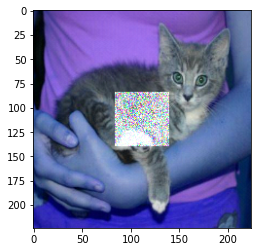

In [15]:
maked_image = preprocessed_images[2][0]+padded_patch[0]

plt.imshow(preprocessed_images[2][0]+padded_patch[0])

1. Patch가 추가된 이미지의 Confidence = 27.49%

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


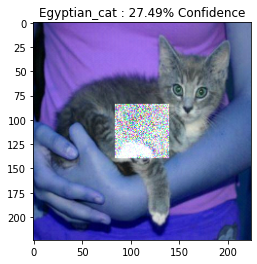

In [16]:
maked_image = np.array(maked_image).reshape((1,224,224,3))

image_probs=pretrained_Model.predict(maked_image)
_,image_class,class_confidence=get_imagenet_label(image_probs)

plt.figure()
plt.imshow(maked_image[0])
_,image_class,class_confidence=get_imagenet_label(image_probs)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

2. 원본 이미지의 Confidence = 11.79%

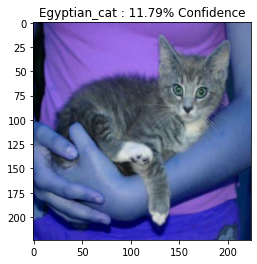

In [17]:
image_probs2=pretrained_Model.predict(preprocessed_images[2])
_,image_class,class_confidence=get_imagenet_label(image_probs2)

plt.imshow(preprocessed_images[2][0])
_,image_class,class_confidence=get_imagenet_label(image_probs2)
plt.title("{} : {:.2f}% Confidence".format(image_class, class_confidence*100))
plt.show()

패치가 추가된 이미지에 대해 더 높은 Confidence가 출력되어짐